# Terphenyl Heteropolymer Analysis Notebook

In this notebook I will perform several data analysis on the RHH terphenyl octamer. This molecule has 3 aromatic moieties connected with peptide-linkers. Collaborators in the Gellman group, at U Wisc-Ma., have been trying to synthesize and characterize this molecule. This would represent a novel type of foldamer molecule.

## Replica Exchange Energy Distributions

For replica exchange data, it is imporant to see the overlap of energy states from each replica. For this reason we will look at the histogram of energies from each simulation and confirm that energies each replica is behaving as expected.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import panedr
import matplotlib.pyplot as plt
import numpy as np
import os
import pymbar
import mdtraj
import heat_capacity
import itertools
from scipy.constants import physical_constants, find
import tqdm
import plotting
import h_bonds
from multiprocessing import Pool

plt.style.use('ggplot')

In [3]:
energy_df = panedr.edr_to_df("/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/sim0/npt.edr")
energy_df.head()

Time         Bond         Angle  Proper Dih.       LJ-14   Coulomb-14  \
0.0      0.0  3476.319336  14484.898438   473.606232  600.466797 -1050.351562   
100.0  100.0  3502.831055  14487.014648   550.683533  594.352966 -1065.079834   
200.0  200.0  3316.188477  14587.367188   554.614258  607.232178 -1044.868652   
300.0  300.0  3395.050049  14413.551758   444.376282  583.858276 -1040.240723   
400.0  400.0  3492.964355  14485.119141   485.414673  610.842896 -1047.402832   

            LJ (SR)  Disper. corr.  Coulomb (SR)  Coul. recip.  ...  \
0.0      477.176941     -29.210785  -5453.289551   1227.846069  ...   
100.0 -11282.683594     -20.597462  -5019.292969    717.184265  ...   
200.0 -11487.283203     -20.709114  -4963.344238    730.007263  ...   
300.0 -11402.691406     -20.525780  -4969.524902    758.597900  ...   
400.0 -11158.217773     -20.684299  -5043.535156    759.867371  ...   

          Pres-YZ     Pres-ZX     Pres-ZY     Pres-ZZ  #Surf*SurfTen  \
0.0    -59.740219  -66.604286  -59.739651 -341.236633   -2889.187744   
100.0   -7.894585  351.736206   -7.891168   22.695278    -489.800720   
200.0  292.284241  182.889084  292.283508 -419.383118   -3540.321045   
300.0   42.175716   43.144127   42.173859  -63.384182    1830.393188   
400.0   67.564667  541.294800   67.562790  719.336487    3305.005371   

       Box-Vel-XX  Box-Vel-YY  Box-Vel-ZZ    T-System  Lamb-System  
0.0      0.000000    0.000000    0.000000  200.326340          1.0  
100.0   -0.000146   -0.000146   -0.000146  203.144241          1.0  
200.0    0.001262    0.001262    0.001262  198.623581          1.0  
300.0    0.002638    0.002638    0.002638  197.848648          1.0  
400.0    0.003554    0.003554    0.003554  200.015839          1.0  

[5 rows x 50 columns]

In [4]:
# Extract Potential Energies from each simulation
sim_dir_name = "sim"
path = "/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/"
n_replicas = 40

energies, temps = heat_capacity.get_energies(sim_dir_name, path, n_replicas)

npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.e

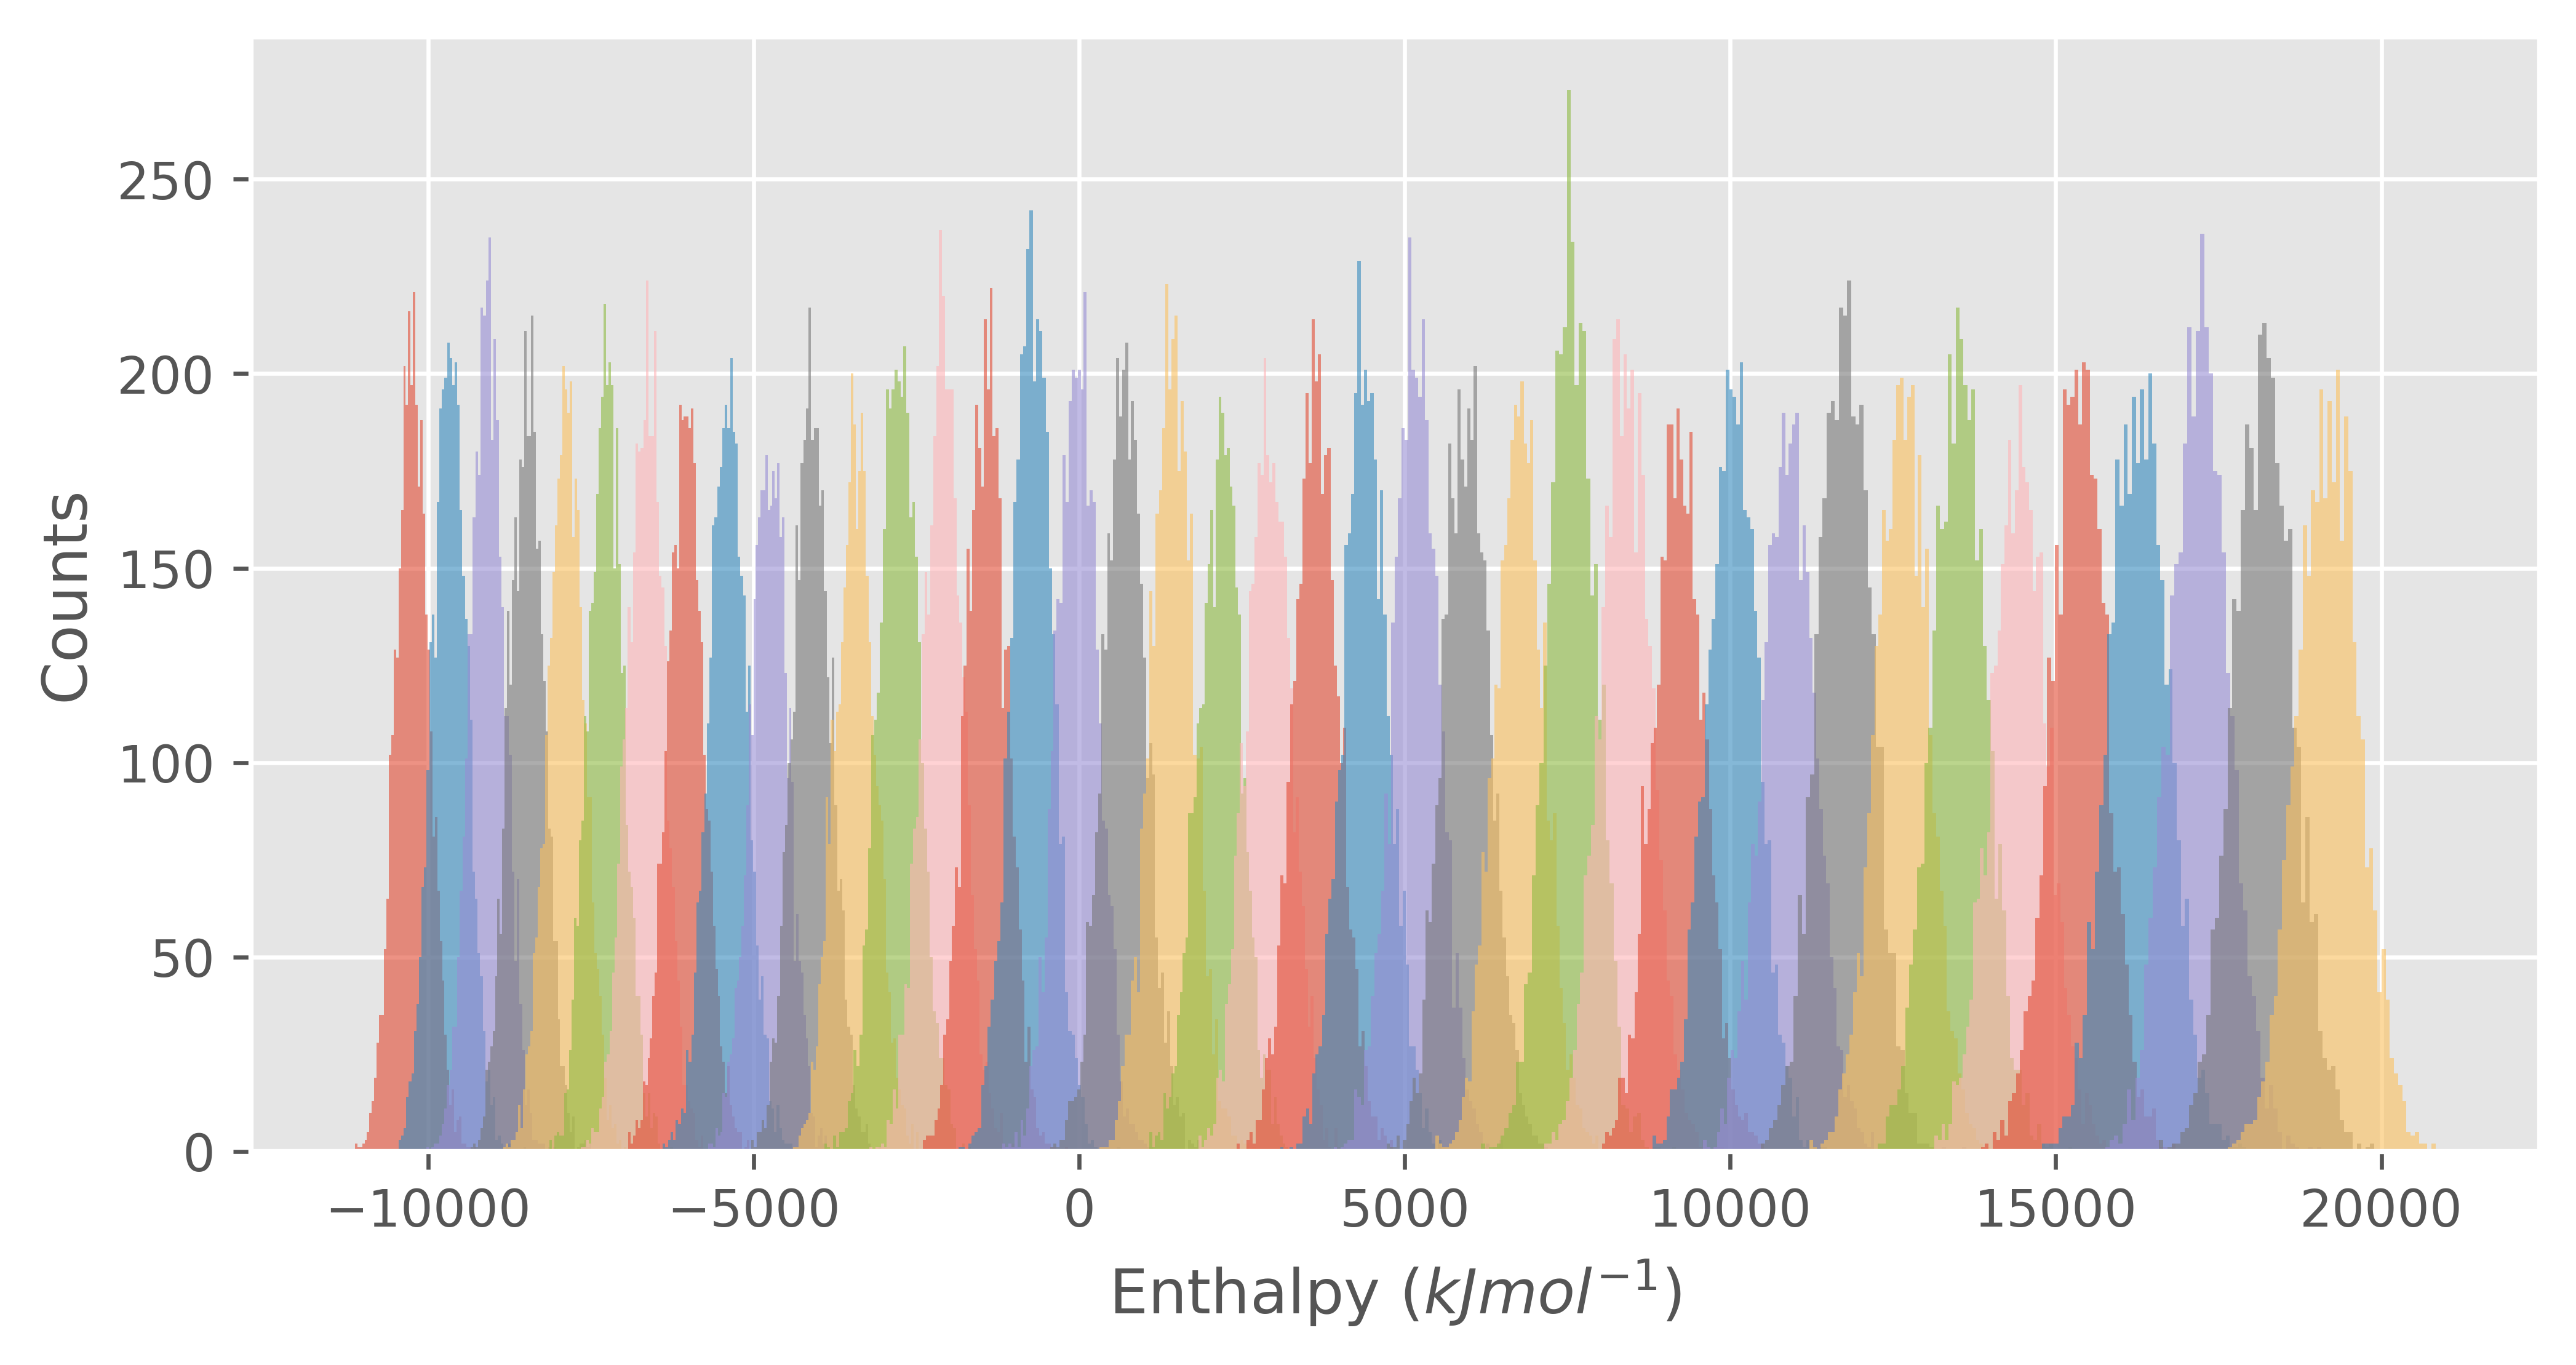

In [5]:
plotting.plot_RE_energy_distributions(energies)

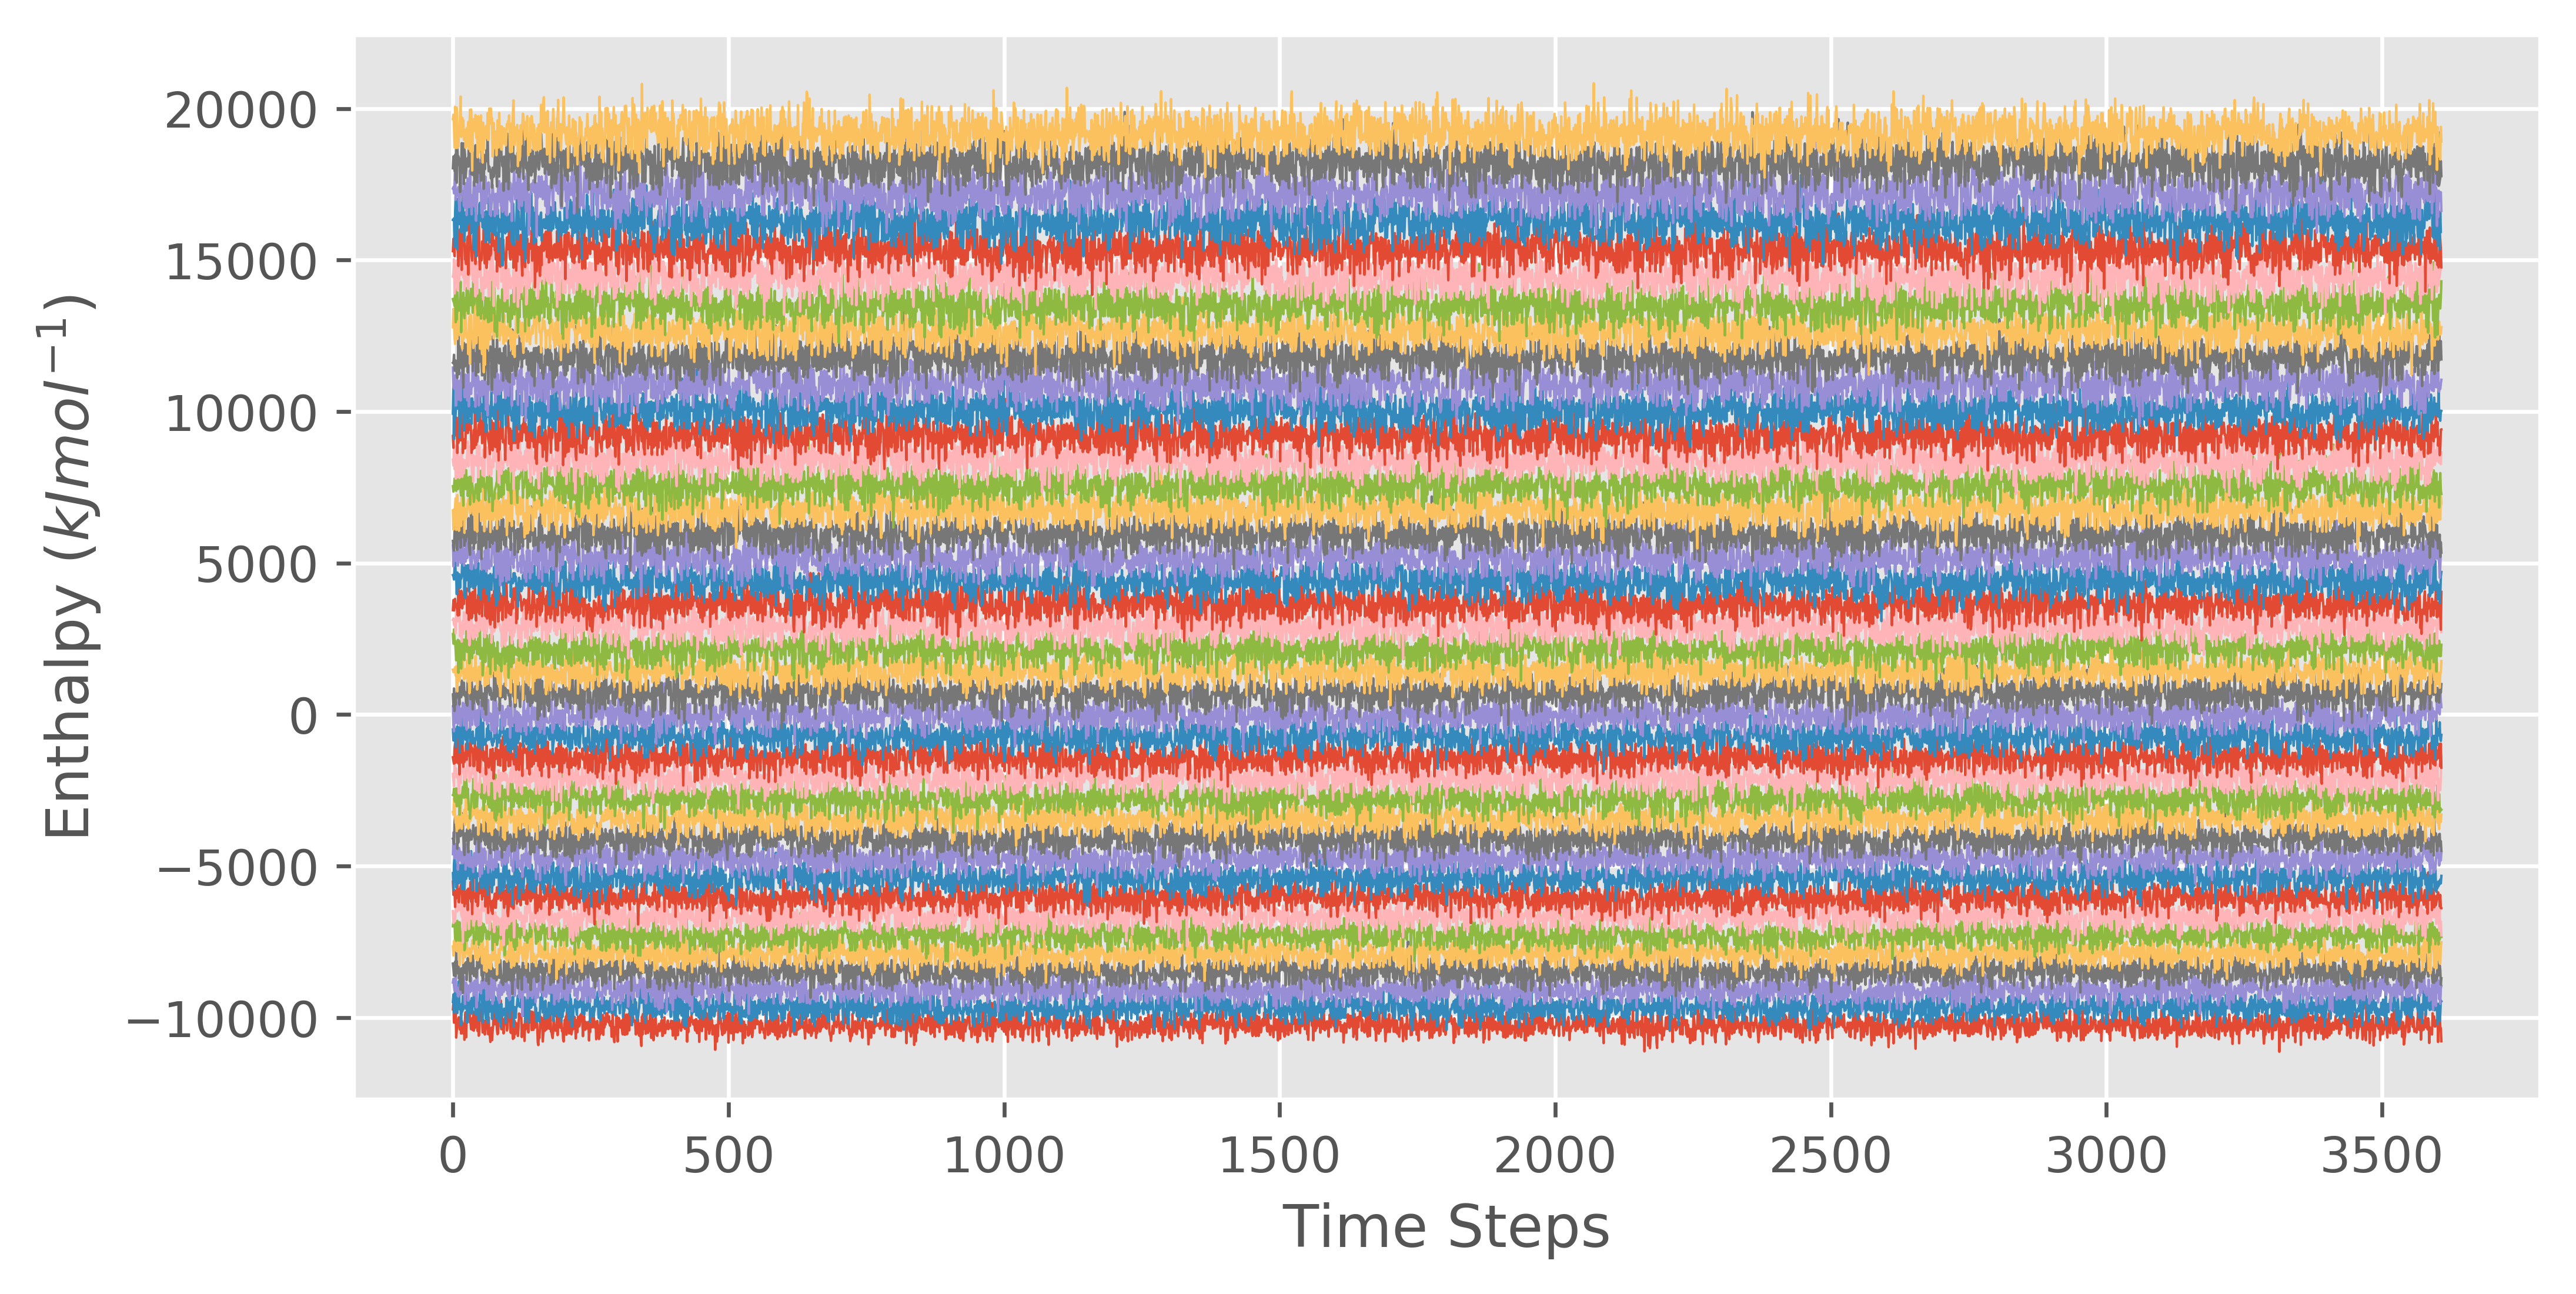

In [6]:
plotting.plot_RE_energy_trajectory(energies)

## Heat Capacity Curve

The nice thing about replica exchange simulations is we can compute the change of a systems heat capacity with temperature.This is especially useful for systems that experience large surface area changes during phase transistions, such as protein folding or melting transitions.

We'll be implementing heat capacity equation, using enthalpy:

$$C_p = \frac{d<H>}{dT}$$

We'll be calculating expectation heat capacities using the following formulas:



In [7]:
u_kln, n_samples, t_list, betas = heat_capacity.construct_u_kln_matrix(temps, energies, add_temps = np.linspace(200, 350, 200))

In [8]:
# MBAR
mbar = pymbar.MBAR(u_kln, n_samples, verbose = True, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)

K (total states) = 240, total samples = 144397

They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.


They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.

N_k = 
[3610 3610 3610 3610 3610 3610 3610 3610 3610 3610 3610 3610 3610 3610
 3610 3610 3610 3610 3610 3610 3610 3610 3610 3609 3610 3610 3610 3610
 3610 3610 3610 3610 3610 3610 3609 3610 3609 3610 3610 3610    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  

In [9]:
# Building potential energy kln matrix
E_kln = u_kln
for k in range(u_kln.shape[1]):
    E_kln[:,k,:] *= betas[k]**(-1)

# mean and variance of energy
results = mbar.computeExpectations(E_kln, state_dependent=True, return_dict=True)
E_expected = results['mu']
dE_expected = results['sigma']

In [10]:
# mean and variance of difference of energies
results = mbar.computeExpectations(E_kln, output='differences', state_dependent=True, return_dict=True)
DeltaE_expected = results['mu']
dDeltaE_expected = results['sigma']

In [11]:
# mean and variance of energies squared
results = mbar.computeExpectations(E_kln**2, state_dependent=True, return_dict=True)
E2_expected = results['mu']
dE2_expected = results['sigma']

In [12]:
kb = physical_constants["Boltzmann constant"][0] *  physical_constants["Avogadro constant"][0] / 1000 # J (molK)^-1

Cp_expect = (E2_expected - (E_expected*E_expected)) / (kb * t_list**2)

In [13]:
Cp_expect = heat_capacity.calculate_cp(mbar, E_kln, t_list)

Text(0.5, 0, 'Temperature (K)')

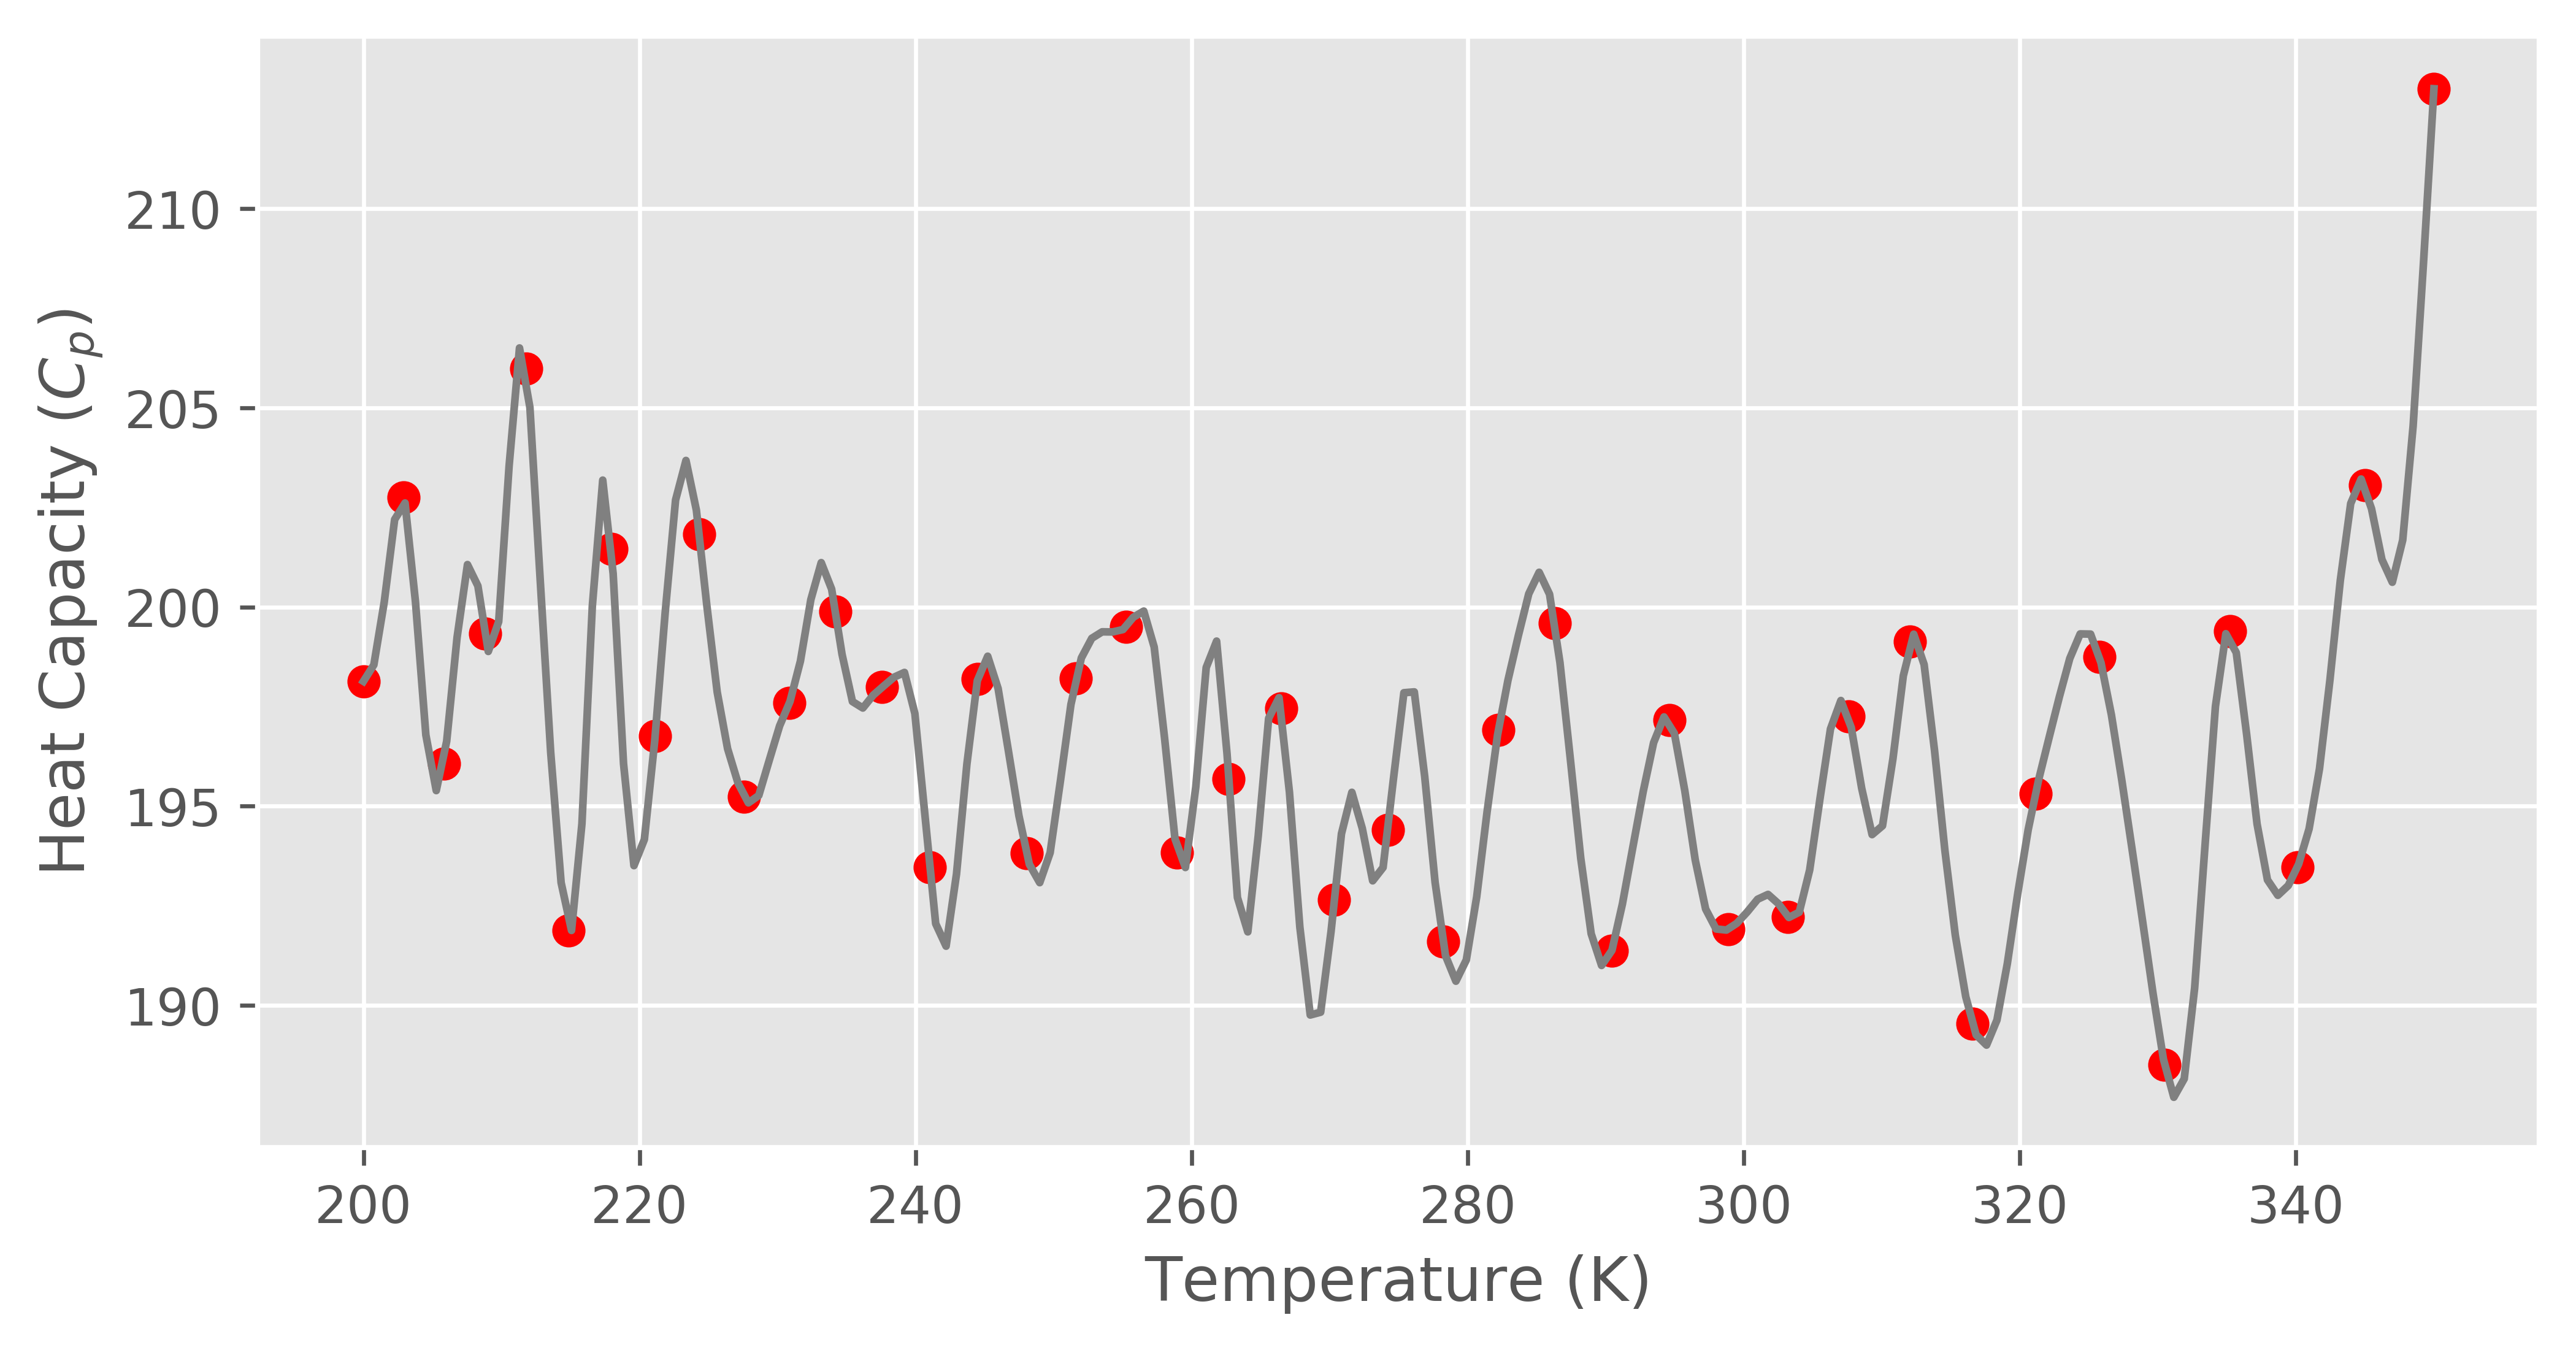

In [14]:
plt.figure(figsize=[8,4], dpi=600)
plt.plot(t_list[40:], Cp_expect[40:], color = "gray")
plt.scatter(t_list[:40], Cp_expect[:40], color = "red")
plt.ylabel("Heat Capacity ($C_p$)")
plt.xlabel("Temperature (K)")

## Bootstrapping Cp Results

We can use bootstrapping to generate uncertainties in our data set.

In [15]:
# Attempted to multiprocess the MBAR Bootstrapping
# But it appears that the optimizations in pymbar parallelize to use all processors
# Or the single process of mbar is extremely memory intensive

def cp_bootstrap(j):
    print("Working on bootstrap", j,"...")
    t1 = time.time()
    energies_boot = []
    for i in range(len(energies)):
        energies_boot.append(np.random.choice(energies[i], size=len(energies[i])))
    # Solve MBAR equations
    u_kln_boot, n_samples_boot, t_list_boot, betas_boot = heat_capacity.construct_u_kln_matrix(temps, energies_boot, add_temps = np.linspace(200, 350, 200))
    mbar_boot = pymbar.MBAR(u_kln_boot, n_samples_boot, verbose = False, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)
    # Compute expectations and variance of relevant terms
    E_kln_boot = u_kln_boot
    for k in range(u_kln_boot.shape[1]):
        E_kln_boot[:,k,:] *= betas_boot[k]**(-1)
    Cp_boot = heat_capacity.calculate_cp(mbar_boot, E_kln_boot, t_list)
    # compute boot strap cp
    t2 = time.time()
    print("bootstraj", j, "took", t2-t1, "seconds")
    return(Cp_boot)
    

In [16]:
from multiprocessing import Pool
import time

N_boots = 100
pool = Pool(1)

cp_boot = pool.map(cp_bootstrap, range(N_boots))

Working on bootstrap 0 ...
bootstraj 0 took 22.338849306106567 seconds
Working on bootstrap 1 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 1 took 21.93376851081848 seconds
Working on bootstrap 2 ...
bootstraj 2 took 21.34227228164673 seconds
Working on bootstrap 3 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 3 took 20.973292350769043 seconds
Working on bootstrap 4 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 4 took 21.675728797912598 seconds
Working on bootstrap 5 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 5 took 22.168389081954956 seconds
Working on bootstrap 6 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 6 took 22.36446738243103 seconds
Working on bootstrap 7 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 7 took 21.277998447418213 seconds
Working on bootstrap 8 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 8 took 21.421236276626587 seconds
Working on bootstrap 9 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 9 took 21.698699712753296 seconds
Working on bootstrap 10 ...
bootstraj 10 took 21.15376925468445 seconds
Working on bootstrap 11 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 11 took 21.427542209625244 seconds
Working on bootstrap 12 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 12 took 21.320891857147217 seconds
Working on bootstrap 13 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 13 took 21.609689235687256 seconds
Working on bootstrap 14 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 14 took 21.488626956939697 seconds
Working on bootstrap 15 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 15 took 21.077163457870483 seconds
Working on bootstrap 16 ...
bootstraj 16 took 21.755868196487427 seconds
Working on bootstrap 17 ...
bootstraj 17 took 20.696685552597046 seconds
Working on bootstrap 18 ...
bootstraj 18 took 21.031380891799927 seconds
Working on bootstrap 19 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 19 took 21.040565729141235 seconds
Working on bootstrap 20 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 20 took 21.10116481781006 seconds
Working on bootstrap 21 ...
bootstraj 21 took 21.056034326553345 seconds
Working on bootstrap 22 ...
bootstraj 22 took 21.179978132247925 seconds
Working on bootstrap 23 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 23 took 21.09434485435486 seconds
Working on bootstrap 24 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 24 took 21.08791208267212 seconds
Working on bootstrap 25 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 25 took 21.15825057029724 seconds
Working on bootstrap 26 ...
bootstraj 26 took 21.1486177444458 seconds
Working on bootstrap 27 ...
bootstraj 27 took 21.066515922546387 seconds
Working on bootstrap 28 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 28 took 20.942644357681274 seconds
Working on bootstrap 29 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 29 took 21.072950839996338 seconds
Working on bootstrap 30 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 30 took 21.01602339744568 seconds
Working on bootstrap 31 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 31 took 21.05027937889099 seconds
Working on bootstrap 32 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 32 took 20.965172290802002 seconds
Working on bootstrap 33 ...
bootstraj 33 took 20.970412731170654 seconds
Working on bootstrap 34 ...
bootstraj 34 took 21.070611715316772 seconds
Working on bootstrap 35 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 35 took 21.13687539100647 seconds
Working on bootstrap 36 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 36 took 21.01443362236023 seconds
Working on bootstrap 37 ...
bootstraj 37 took 21.337512254714966 seconds
Working on bootstrap 38 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 38 took 21.082648515701294 seconds
Working on bootstrap 39 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 39 took 21.035732746124268 seconds
Working on bootstrap 40 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 40 took 21.15350103378296 seconds
Working on bootstrap 41 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 41 took 21.338470697402954 seconds
Working on bootstrap 42 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 42 took 21.057788133621216 seconds
Working on bootstrap 43 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 43 took 21.28100347518921 seconds
Working on bootstrap 44 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 44 took 21.355523824691772 seconds
Working on bootstrap 45 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 45 took 20.938538312911987 seconds
Working on bootstrap 46 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 46 took 21.057933568954468 seconds
Working on bootstrap 47 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 47 took 21.12069582939148 seconds
Working on bootstrap 48 ...
bootstraj 48 took 21.3762845993042 seconds
Working on bootstrap 49 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 49 took 21.098689794540405 seconds
Working on bootstrap 50 ...
bootstraj 50 took 20.993839979171753 seconds
Working on bootstrap 51 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 51 took 21.327900171279907 seconds
Working on bootstrap 52 ...
bootstraj 52 took 20.99022650718689 seconds
Working on bootstrap 53 ...
bootstraj 53 took 21.039710521697998 seconds
Working on bootstrap 54 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 54 took 21.041827917099 seconds
Working on bootstrap 55 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 55 took 20.831310987472534 seconds
Working on bootstrap 56 ...
bootstraj 56 took 21.045175790786743 seconds
Working on bootstrap 57 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 57 took 21.096810340881348 seconds
Working on bootstrap 58 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 58 took 21.338033199310303 seconds
Working on bootstrap 59 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 59 took 21.00110912322998 seconds
Working on bootstrap 60 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 60 took 21.04978609085083 seconds
Working on bootstrap 61 ...
bootstraj 61 took 21.14421010017395 seconds
Working on bootstrap 62 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 62 took 21.03312349319458 seconds
Working on bootstrap 63 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 63 took 21.096946716308594 seconds
Working on bootstrap 64 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 64 took 21.314987897872925 seconds
Working on bootstrap 65 ...
bootstraj 65 took 21.330496311187744 seconds
Working on bootstrap 66 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 66 took 21.35490608215332 seconds
Working on bootstrap 67 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 67 took 21.48699450492859 seconds
Working on bootstrap 68 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 68 took 21.61946415901184 seconds
Working on bootstrap 69 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 69 took 21.54959988594055 seconds
Working on bootstrap 70 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 70 took 21.071358680725098 seconds
Working on bootstrap 71 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 71 took 21.069160223007202 seconds
Working on bootstrap 72 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 72 took 21.07926344871521 seconds
Working on bootstrap 73 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 73 took 20.990092039108276 seconds
Working on bootstrap 74 ...
bootstraj 74 took 21.071799755096436 seconds
Working on bootstrap 75 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 75 took 21.262251138687134 seconds
Working on bootstrap 76 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 76 took 21.40744113922119 seconds
Working on bootstrap 77 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 77 took 21.343631744384766 seconds
Working on bootstrap 78 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 78 took 21.64156985282898 seconds
Working on bootstrap 79 ...
bootstraj 79 took 21.66287660598755 seconds
Working on bootstrap 80 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 80 took 21.519373893737793 seconds
Working on bootstrap 81 ...
bootstraj 81 took 21.397164344787598 seconds
Working on bootstrap 82 ...
bootstraj 82 took 21.221216917037964 seconds
Working on bootstrap 83 ...
bootstraj 83 took 21.764532566070557 seconds
Working on bootstrap 84 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 84 took 21.28466796875 seconds
Working on bootstrap 85 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 85 took 21.532785654067993 seconds
Working on bootstrap 86 ...
bootstraj 86 took 21.638753652572632 seconds
Working on bootstrap 87 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 87 took 21.94176411628723 seconds
Working on bootstrap 88 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 88 took 21.873924255371094 seconds
Working on bootstrap 89 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 89 took 22.00668954849243 seconds
Working on bootstrap 90 ...
bootstraj 90 took 21.253250122070312 seconds
Working on bootstrap 91 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 91 took 21.513236045837402 seconds
Working on bootstrap 92 ...
bootstraj 92 took 22.1530339717865 seconds
Working on bootstrap 93 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 93 took 21.93206477165222 seconds
Working on bootstrap 94 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 94 took 21.912792921066284 seconds
Working on bootstrap 95 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 95 took 21.47755527496338 seconds
Working on bootstrap 96 ...
bootstraj 96 took 22.03297233581543 seconds
Working on bootstrap 97 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 97 took 21.539453983306885 seconds
Working on bootstrap 98 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 98 took 21.45445418357849 seconds
Working on bootstrap 99 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 99 took 21.515750646591187 seconds


In [17]:
cp_boot = np.array(cp_boot)

[autoreload of plotting failed: Traceback (most recent call last):
  File "/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _cal

In [18]:
mu_cp_boot = np.mean(cp_boot, axis = 0)
sigma_cp_boot = np.std(cp_boot, axis = 0)

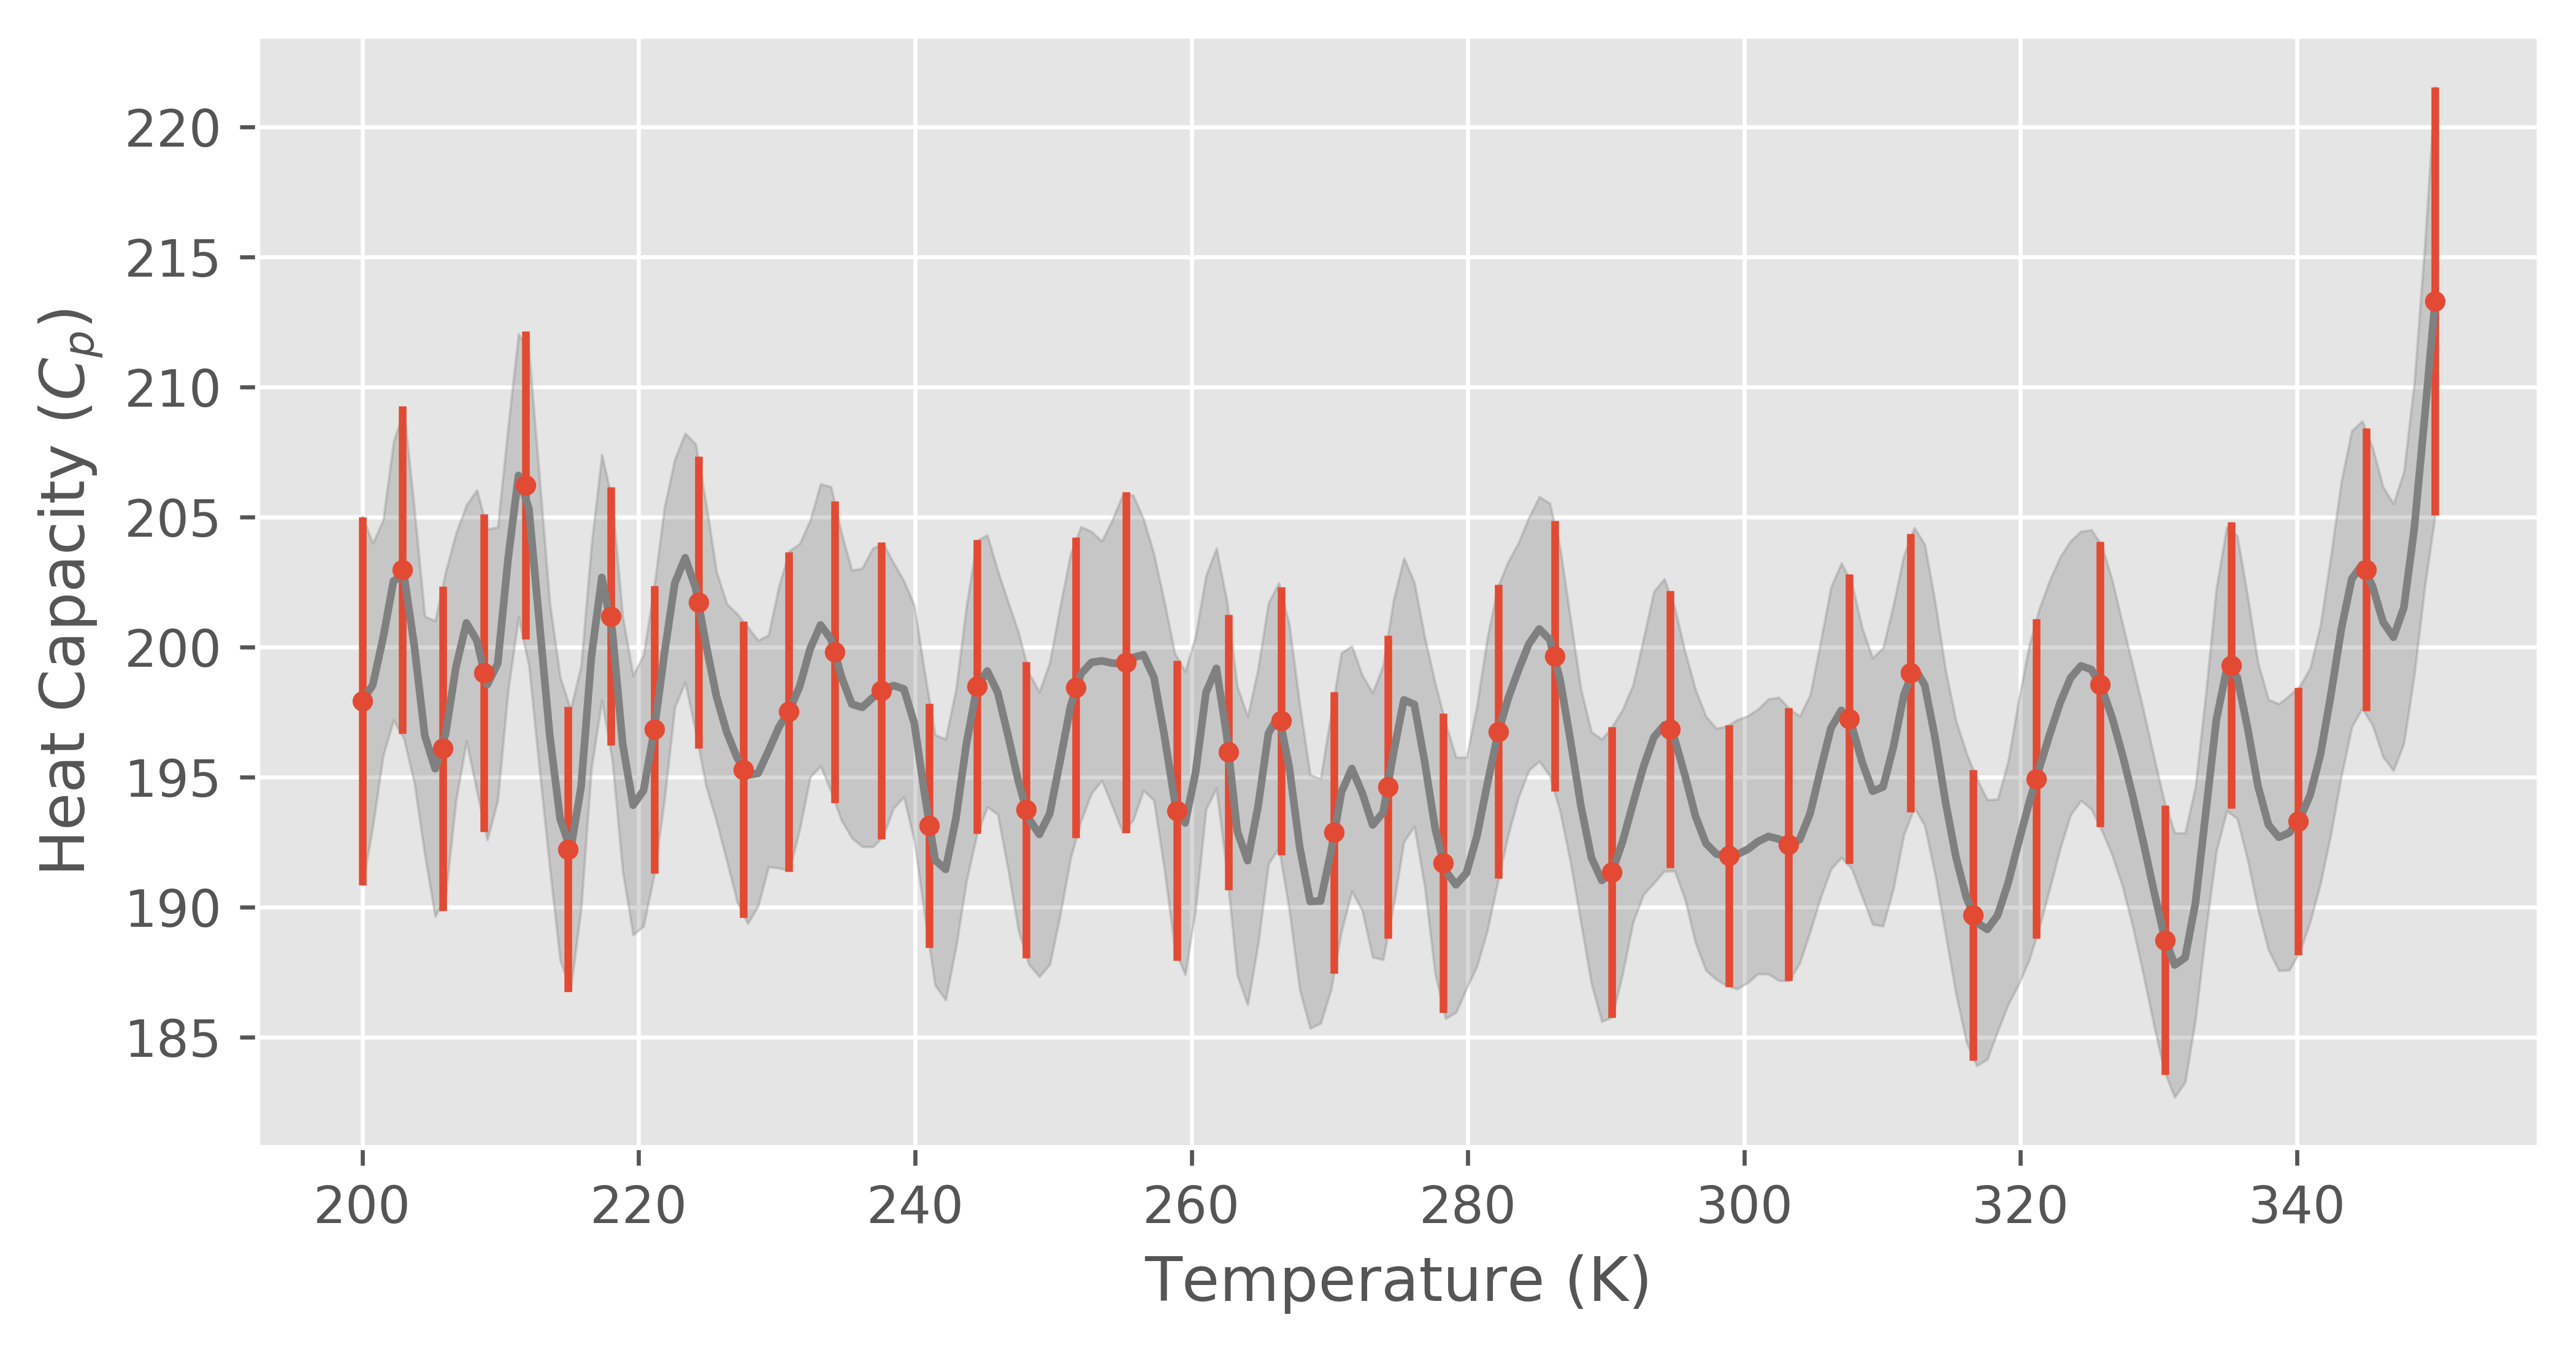

In [19]:
plotting.plot_bootstrapped_heat_capacity(mu_cp_boot, sigma_cp_boot, t_list, 40)

## H-Bonding with Temperature

Since we're unsure whether the Cp spike we're observing at 225 K is due to the solvent or the molecule, we need to investigate the average hydrogen bonds formed in each replica simulation. This will confirm if there is a significant change in the number of hydrogen bonds at low temperatures, indicating that the terphenyl molecule may be giving rise to the large heat capacity spike.

In [10]:
remd_trajs = h_bonds.REMD_trajectories("/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K", "npt", "whole.xtc","sim", "/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/sim0/berendsen.gro", np = 1)

Replica 0
['#npt.edr.1#', '#npt.edr.2#', '#npt.edr.3#', '#npt.log.1#', '#npt.log.2#', '#npt.log.3#', '#npt.log.4#', '#npt.log.5#', '#npt.log.6#', '#npt.log.7#', '#npt.part0002.edr.1#', '#npt.part0002.log.1#', '#npt.part0002.trr.1#', '#npt.part0003.edr.1#', '#npt.part0003.log.1#', '#npt.part0003.trr.1#', '#npt.part0004.edr.1#', '#npt.part0004.log.1#', '#npt.part0004.trr.1#', '#npt.tpr.1#', '#npt.tpr.10#', '#npt.tpr.11#', '#npt.tpr.12#', '#npt.tpr.13#', '#npt.tpr.14#', '#npt.tpr.15#', '#npt.tpr.16#', '#npt.tpr.17#', '#npt.tpr.18#', '#npt.tpr.19#', '#npt.tpr.2#', '#npt.tpr.20#', '#npt.tpr.21#', '#npt.tpr.22#', '#npt.tpr.23#', '#npt.tpr.24#', '#npt.tpr.25#', '#npt.tpr.26#', '#npt.tpr.27#', '#npt.tpr.28#', '#npt.tpr.29#', '#npt.tpr.3#', '#npt.tpr.30#', '#npt.tpr.31#', '#npt.tpr.32#', '#npt.tpr.33#', '#npt.tpr.34#', '#npt.tpr.35#', '#npt.tpr.36#', '#npt.tpr.37#', '#npt.tpr.38#', '#npt.tpr.39#', '#npt.tpr.4#', '#npt.tpr.40#', '#npt.tpr.41#', '#npt.tpr.42#', '#npt.tpr.43#', '#npt.tpr.44#', '#n

['#npt.tpr.1#', '#npt.tpr.10#', '#npt.tpr.11#', '#npt.tpr.12#', '#npt.tpr.13#', '#npt.tpr.14#', '#npt.tpr.15#', '#npt.tpr.16#', '#npt.tpr.17#', '#npt.tpr.18#', '#npt.tpr.19#', '#npt.tpr.2#', '#npt.tpr.20#', '#npt.tpr.21#', '#npt.tpr.22#', '#npt.tpr.23#', '#npt.tpr.24#', '#npt.tpr.25#', '#npt.tpr.26#', '#npt.tpr.27#', '#npt.tpr.28#', '#npt.tpr.29#', '#npt.tpr.3#', '#npt.tpr.30#', '#npt.tpr.31#', '#npt.tpr.32#', '#npt.tpr.33#', '#npt.tpr.34#', '#npt.tpr.35#', '#npt.tpr.36#', '#npt.tpr.37#', '#npt.tpr.38#', '#npt.tpr.39#', '#npt.tpr.4#', '#npt.tpr.40#', '#npt.tpr.41#', '#npt.tpr.42#', '#npt.tpr.43#', '#npt.tpr.44#', '#npt.tpr.45#', '#npt.tpr.46#', '#npt.tpr.47#', '#npt.tpr.48#', '#npt.tpr.49#', '#npt.tpr.5#', '#npt.tpr.50#', '#npt.tpr.51#', '#npt.tpr.52#', '#npt.tpr.53#', '#npt.tpr.54#', '#npt.tpr.55#', '#npt.tpr.56#', '#npt.tpr.57#', '#npt.tpr.58#', '#npt.tpr.59#', '#npt.tpr.6#', '#npt.tpr.60#', '#npt.tpr.61#', '#npt.tpr.62#', '#npt.tpr.63#', '#npt.tpr.64#', '#npt.tpr.65#', '#npt.tpr.66#

ValueError: list.remove(x): x not in list

In [11]:
remd_trajs.trajs[0][0].top

NameError: name 'remd_trajs' is not defined

In [ ]:
h_bond_finder = h_bonds.HydrogenBondFinder(remd_trajs.trajs[0][0], remd_trajs.trajs[0][0].top)
h_bond_finder.get_donors()
h_bond_finder.get_acceptors()
n_h_bonds, h_bond_ids = h_bond_finder.get_hydrogen_bonds(remd_trajs.trajs[0])

In [ ]:
pool = Pool(8)

In [ ]:
n_h_bonds_remd, h_bonds_remd = zip(*pool.map(h_bond_finder.get_hydrogen_bonds, remd_trajs.trajs))

In [ ]:
n_h_bonds_remd = np.array(n_h_bonds_remd)
h_bonds_remd = h_bonds_remd

In [ ]:
temps = np.array(remd_trajs.temps)

In [ ]:
plt.scatter(temps, np.mean(n_h_bonds_remd, axis = 1))
plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Replica Temperature")

In [ ]:
n_h_bonds_remd.shape

In [ ]:
h_bonds_kln = np.zeros(u_kln.shape)
for k in range(n_h_bonds_remd.shape[0]):
    for l in range(h_bonds_kln.shape[0]):
        h_bonds_kln[k,l,:] = n_h_bonds_remd[k]

In [ ]:
E_kln.shape

In [ ]:
h_bonds_kln.shape

In [ ]:
results = mbar.computeExpectations(h_bonds_kln, state_dependent=True, return_dict=True)

h_bonds_mu = results["mu"]
h_bonds_sigma = results["sigma"]

In [ ]:
plt.figure(figsize=[8,4], dpi=600)
plt.scatter(t_list[:20], h_bonds_mu[:20])
plt.plot(t_list[20:], h_bonds_mu[20:], c="gray")
plt.errorbar(t_list[:20], h_bonds_mu[:20], yerr=2*h_bonds_sigma[:20], fmt=".")
plt.fill_between(t_list[20:], h_bonds_mu[20:]-2*h_bonds_sigma[20:],  h_bonds_mu[20:]+2*h_bonds_sigma[20:], color="gray", alpha = 0.3)


plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Replica Temperature")

## Dihedral Analysis + Classification

We want to address what structural motifs are present in the terphenyl oligamer as it is subjected to the temperature changes of REMD. We will rerun the torsion analysis we ran on the vanilla MD simulations to confirm that the distributions are similar (meaning that we effectively sampled these distributions on our first pass) and to classify monomer structures to see what are typical conformations.

The goal of this analysis is to be able to extract specific frames coresponding to specific "classified" structures.

In [ ]:
import utils

In [ ]:
torsion_ids = ["A", "B", "CC", "D", "E", "F", "G"]

torsion_annotations = [[torsion_id + str(i) for i in range(1, 5)] for torsion_id in torsion_ids]

Here we output the atoms making up the torsion we want to look at. These torsions are extracted from an annotated .itp file which has speicifc atoms manually selected. There are torsions A-G (with C being represented as CC to not be confused with carbon naming). Here we show that can extract torsions at all temperatures.

In [ ]:
itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
selector = itp_reader.construct_dihe_selection(torsion_annotations[1])

In [ ]:
dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])

In [ ]:
torsions_temps = []
for i_rep in range(remd_trajs.n_replicas):
    dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
    torsions_temps.append(dihes_t)

In [ ]:
for torsions in torsions_temps:
    plt.hist(torsions, alpha = 0.1, bins=50, density=True)
plt.xlabel("Torsion X")
plt.ylabel("Density")

## All 1D Torsion Distributions

In [ ]:
torsion_matrix = []
for i_torsions in range(len(torsion_annotations)):
    itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
    selector = itp_reader.construct_dihe_selection(torsion_annotations[i_torsions])
    dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])
    torsions_temps = []
    for i_rep in range(remd_trajs.n_replicas):
        dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
        torsions_temps.append(dihes_t)
    plt.figure()
    for torsions in torsions_temps:
        hist = plt.hist(torsions, alpha = 0.1, bins=50, density=True)
    plt.xlabel("Torsion " + str(i_torsions))
    plt.ylabel("Density") 

## Monomer Classification

We can now extract the torsions for each temperature

In [ ]:
classification_matrix = []
for i_torsions in range(len(torsion_annotations)):
    itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
    selector = itp_reader.construct_dihe_selection(torsion_annotations[i_torsions])
    dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])
    torsions_temps = []
    for i_rep in range(remd_trajs.n_replicas):
        dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
        torsions_temps.append(dihes_t)
    all_torsions = np.array(torsions_temps)
    # print(all_torsions.shape)
    total_torsions = all_torsions.shape[1]
    all_torsions = all_torsions.reshape(6, all_torsions.shape[0], int(total_torsions/6))
    classification_matrix.append(all_torsions)
    
classification_matrix = np.array(classification_matrix)

In [ ]:
# Indicies represent:
# 1. Torsions
# 2. Residues
# 3. Temperature
# 4. frames
print(classification_matrix.shape)

In [ ]:
per_monomer_torsions = classification_matrix.reshape(classification_matrix.shape[0], -1)
print(per_monomer_torsions.shape)

# Convert to x and y components of torsions to remove periodic variables
per_monomer_torsions_comp = []
for i in range(per_monomer_torsions.shape[0]):
    per_monomer_torsions_comp.append(np.cos(per_monomer_torsions[i, :]))
    per_monomer_torsions_comp.append(np.sin(per_monomer_torsions[i, :]))
per_monomer_torsions_comp = np.array(per_monomer_torsions_comp)

In [ ]:
per_monomer_torsions[:,0]

In [ ]:
per_monomer_class = []
for i in range(per_monomer_torsions.shape[1]):
    id_str = ""
    torsions =  per_monomer_torsions[:, i]
    
    # Torsion 0
    if  torsions[0] >= -np.pi and torsions[0] <= -np.pi/2:
        id_str += "0"
    elif torsions[0] >= -np.pi/2 and torsions[0] <= 0:
        id_str += "1"
    elif torsions[0] >= 0 and torsions[0] <= np.pi/2:
        id_str += "2"
    elif torsions[0] >= np.pi/2 and torsions[0] <= np.pi:
        id_str += "3"
        
    # Torsion 3
    if  torsions[2] >= -np.pi and torsions[2] <= -np.pi/2:
        id_str += "0"
    elif torsions[2] >= -np.pi/2 and torsions[2] <= 0:
        id_str += "1"
    elif torsions[2] >= 0 and torsions[2] <= np.pi/2:
        id_str += "2"
    elif torsions[2] >= np.pi/2 and torsions[2] <= np.pi:
        id_str += "3"
    
    # Torsion 4
    if  torsions[3] >= - np.pi and torsions[3] <= 0:
        id_str += "0"
    elif  torsions[3] >= 0 and torsions[3] <= np.pi:
        id_str += "1"
        
    # Torsion 4
    if np.abs(torsions[6]) <= np.pi/2:
        id_str += "0"
    elif np.abs(torsions[6]) >= np.pi/2:
        id_str += "1"
        
    # Add to list
    per_monomer_class.append(id_str)
    
per_monomer_class = np.array(per_monomer_class)

In [ ]:
np.sort(counts)[::-1]

In [ ]:
unique, counts = np.unique(per_monomer_class, return_counts=True)
unique = [x for _,x in sorted(zip(counts, unique))][::-1]
counts = np.sort(counts)[::-1]
print("Total Populated Monomer Types:", len(unique))
for i in range(len(unique)):
    print(unique[i], ":", counts[i])

In [ ]:
per_structure_temperature_class.shape

In [ ]:
for a, b in zip(*np.where(per_structure_temperature_class[:, 0, :] == "3300")):
    print("Frame:", b, "Residue", a)

In [ ]:
import pandas
per_structure_temperature_class = per_monomer_class.reshape(6, 20, 3624)
pandas.DataFrame(per_structure_temperature_class[:, 0, 50:55])


## Clustering based on angle components

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [ ]:
bandwidth = estimate_bandwidth(per_monomer_torsions_comp.T, quantile=0.4, n_jobs=-1, n_samples = 1000)

In [ ]:
bandwidth = 1.0

In [ ]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)

In [ ]:
ms.fit(per_monomer_torsions_comp.T)

In [ ]:
labels = ms.labels_
np.unique(labels)

In [ ]:
label_per_residue_temp_frame = labels.reshape(*classification_matrix.shape[1:])
label_per_residue_temp_frame.shape

In [ ]:
loc = np.where(label_per_residue_temp_frame == 0)
np.array(loc).T.shape

In [ ]:
unique, counts = np.unique(labels,return_counts=True)

In [ ]:
unique

In [ ]:
counts

In [ ]:
ms.cluster_centers_.shape

In [ ]:
cluster_torsions = ms.cluster_centers_

In [ ]:
torsion = 0
plt.scatter(per_monomer_torsions_comp[2*torsion,:], per_monomer_torsions_comp[2*torsion + 1,:], alpha=0.002, c="black")
plt.scatter(cluster_torsions[0,2*torsion], cluster_torsions[0,2*torsion + 1])